In [7]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [8]:
data_train = pd.read_csv('files/Houses_train.csv')
data_test = pd.read_csv('files/Houses_test.csv')
y = data_train['SalePrice']
X = data_train.drop(columns=['Id', 'SalePrice'])

<AxesSubplot:>

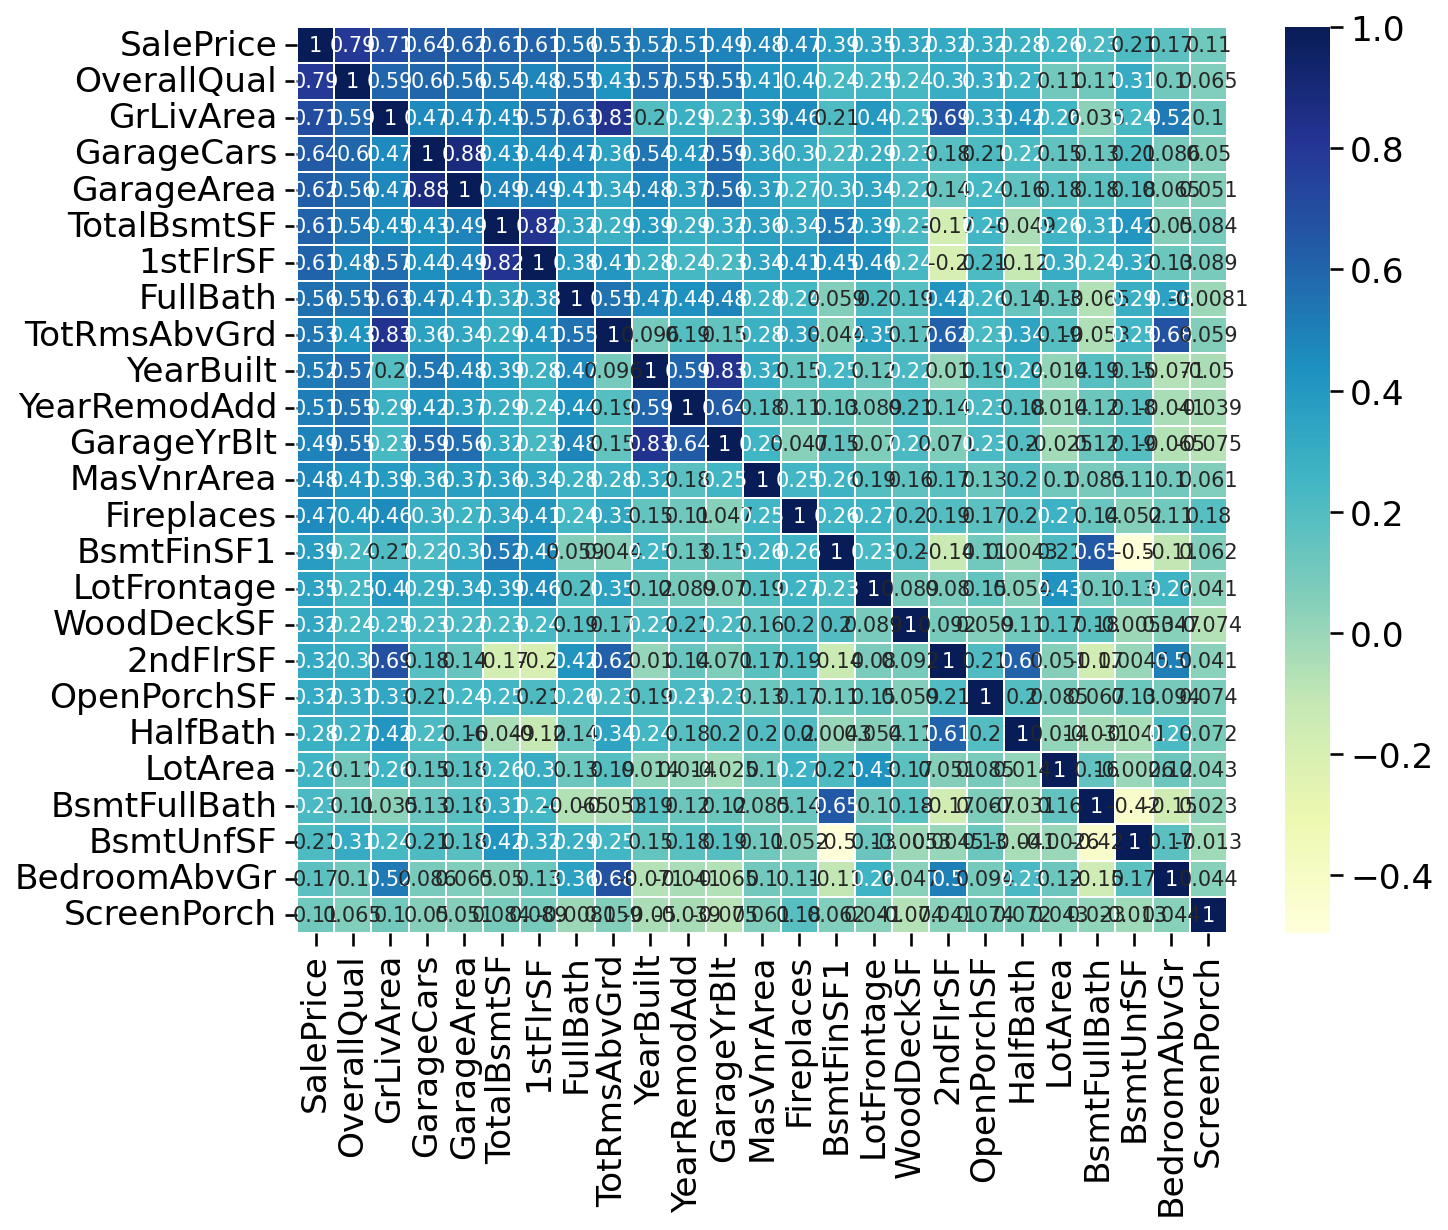

In [9]:
corrM = data_train.corr()
fig, ax = plt.subplots(dpi = 150, figsize=(10, 8))
cols = corrM.nlargest(25, 'SalePrice')['SalePrice'].index
sns.heatmap(corrM.loc[cols, cols], annot=True, cmap="YlGnBu", linewidths=0.1,)

<AxesSubplot:>

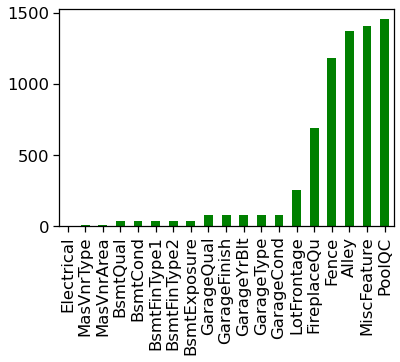

In [10]:
miss_data = data_train.isnull().sum().sort_values()
miss_data[miss_data > 0].plot.bar(color='green')

In [5]:
cols & miss_data[miss_data > 0].index 

Index(['GarageYrBlt', 'MasVnrArea', 'LotFrontage'], dtype='object')

We will fill it

In [11]:
data_train[['GarageYrBlt', 'MasVnrArea', 'LotFrontage']] = data_train[['GarageYrBlt', 'MasVnrArea', 'LotFrontage']].fillna(0)

In [12]:
miss_data = data_train.isnull().sum().sort_values()
data_train = data_train.drop(columns=miss_data[miss_data > 0].index)

In [14]:
quant = np.quantile(data_train.SalePrice, 0.98)
data_train.loc[data_train.SalePrice > quant, 'SalePrice'] = quant

In [15]:
data_train = data_train.drop(data_train[data_train['Id'] == 1299].index)
data_train = data_train.drop(data_train[data_train['Id'] == 524].index)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

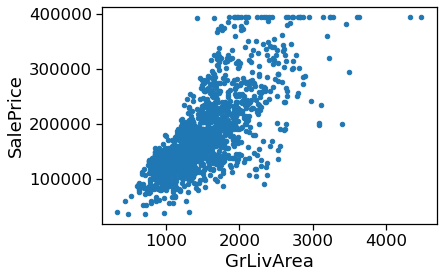

In [16]:
data_train.plot.scatter(x='GrLivArea', y='SalePrice')

In [17]:
y = data_train['SalePrice']
X = data_train.drop(columns=['Id', 'SalePrice'])

In [18]:
X.select_dtypes(include='object').describe().iloc[:, :14]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl
count,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,7
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg
freq,1149,1452,925,1311,1457,1051,1380,225,1260,1444,1218,726,1141,1433


In [19]:
X.select_dtypes(include='object').describe().iloc[:, 14:]

,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
count,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458
unique,15,16,4,5,6,6,5,2,4,7,3,9,6
top,VinylSd,VinylSd,TA,TA,PConc,GasA,Ex,Y,TA,Typ,Y,WD,Normal
freq,515,504,906,1280,645,1426,739,1363,735,1358,1338,1267,1198


In [20]:
X['YearBuilt'] = X.YearBuilt.astype('object')
X['OverallQual'] = X.OverallQual.astype('object')

In [21]:
categorical = X.select_dtypes(include='object').columns
numeric = X.select_dtypes(exclude='object').columns


column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

X_transform = column_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.25, random_state=42)

pipeline = Pipeline(steps=[
    ('regression', RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42))
])

model = pipeline.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test), squared=False)

21823.931385778924

''

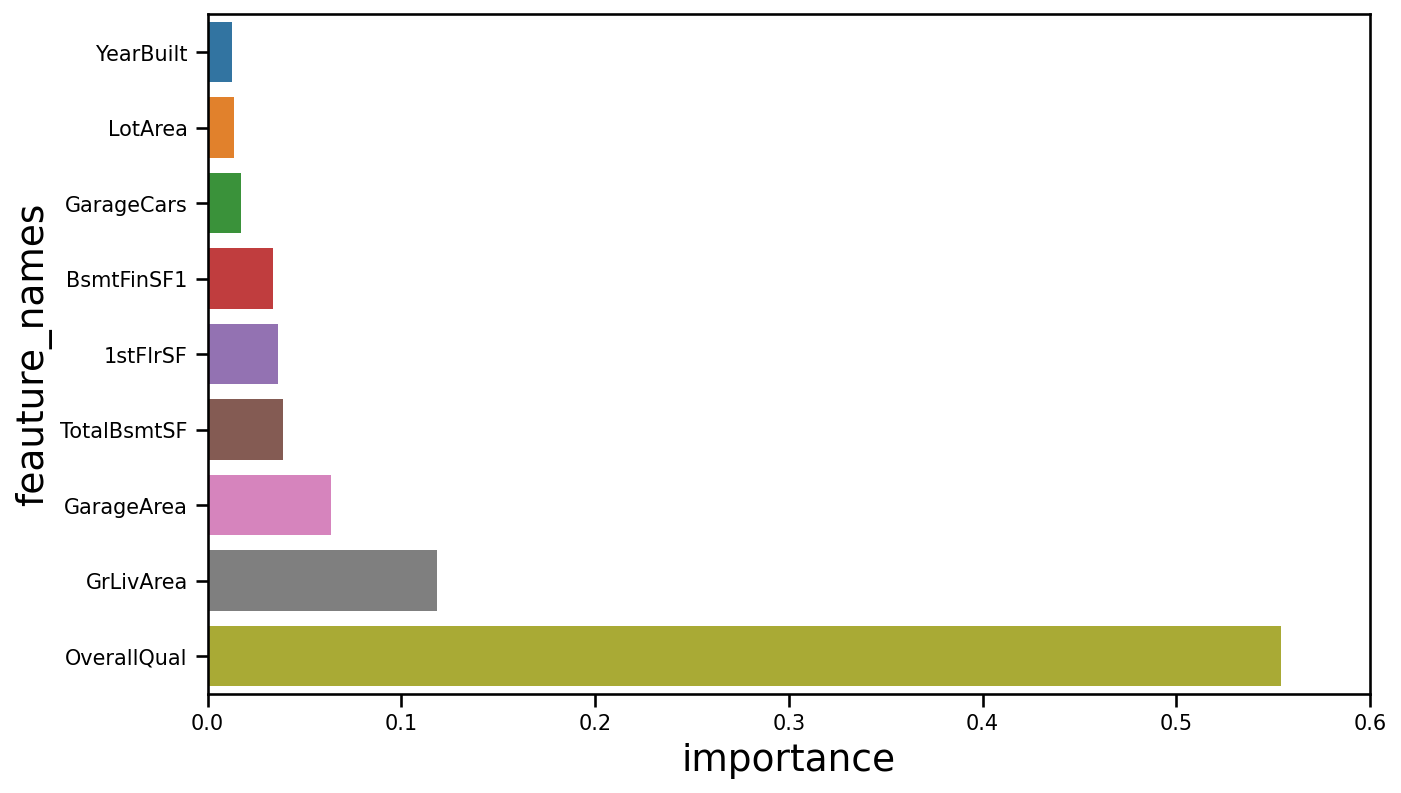

In [22]:
feat_importance = pd.DataFrame({'feauture_names': list(categorical) + list(numeric), 'importance': model.steps[0][1].feature_importances_}).sort_values('importance')
feat_importance = feat_importance.loc[feat_importance.importance > 0.01, :]
fig, ax = plt.subplots(dpi=150, figsize=(10, 6))
sns.barplot(x=feat_importance['importance'], y=feat_importance['feauture_names'])
ax.set_xticks([0.1*i for i in range(7)], ['{:2.1f}'.format(0.1*i) for i in range(7)], fontsize=10)
ax.set_yticks([i for i in range(feat_importance['feauture_names'].values.shape[0])], list(feat_importance['feauture_names'].values), fontsize=10)
''

In [23]:
xgboost = XGBRegressor(n_estimators=300, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(X_train, y_train)
mean_squared_error(y_test, xgboost.predict(X_test), squared=False)

21139.039574324004

In [18]:
ansers = data_test['Id']
data_test = data_test.drop(data_test.columns.difference(X.columns), axis=1)
data_test[['GarageYrBlt', 'MasVnrArea', 'LotFrontage']] = data_test[['GarageYrBlt', 'MasVnrArea', 'LotFrontage']].fillna(0)
miss_data = data_test.isnull().sum().sort_values()

In [19]:
data_test[list(miss_data[miss_data > 0].index)].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,SaleType,Exterior2nd,GarageArea,GarageCars,Exterior1st,KitchenQual,Utilities,Functional,BsmtFullBath,BsmtHalfBath,MSZoning
0,468.0,144.0,270.0,882.0,WD,VinylSd,730.0,1.0,VinylSd,TA,AllPub,Typ,0.0,0.0,RH
1,923.0,0.0,406.0,1329.0,WD,Wd Sdng,312.0,1.0,Wd Sdng,Gd,AllPub,Typ,0.0,0.0,RL
2,791.0,0.0,137.0,928.0,WD,VinylSd,482.0,2.0,VinylSd,TA,AllPub,Typ,0.0,0.0,RL
3,602.0,0.0,324.0,926.0,WD,VinylSd,470.0,2.0,VinylSd,Gd,AllPub,Typ,0.0,0.0,RL
4,263.0,0.0,1017.0,1280.0,WD,HdBoard,506.0,2.0,HdBoard,Gd,AllPub,Typ,0.0,0.0,RL


In [20]:
data_test[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']] = data_test[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']].fillna(data_test[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']].mean())

In [21]:
miss_data = data_test.isnull().sum().sort_values()
data_test[list(miss_data[miss_data > 0].index)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SaleType      1458 non-null   object 
 1   Exterior2nd   1458 non-null   object 
 2   KitchenQual   1458 non-null   object 
 3   GarageCars    1458 non-null   float64
 4   Exterior1st   1458 non-null   object 
 5   BsmtFullBath  1457 non-null   float64
 6   BsmtHalfBath  1457 non-null   float64
 7   Functional    1457 non-null   object 
 8   Utilities     1457 non-null   object 
 9   MSZoning      1455 non-null   object 
dtypes: float64(3), object(7)
memory usage: 114.1+ KB


In [22]:
data_test = data_test.fillna(data_test.mode().iloc[0])

In [23]:
all_df=pd.concat([X, data_test], ignore_index=True,sort=False)
all_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


In [24]:
categorical = X.select_dtypes(include='object').columns
numeric = X.select_dtypes(exclude='object').columns


column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

X_transform = column_transformer.fit_transform(all_df)

In [25]:
X_train = X_transform[:1000]
y_train = y[:1000]
X_test = X_transform[1000:1458]
y_test = y[1000:1458]
xgboost = XGBRegressor(n_estimators=300, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(X_train, y_train)
mean_squared_error(y_test, xgboost.predict(X_test), squared=False)

21063.815099133957

In [42]:
X_train = X_transform[:1458]
y_train = y[:1458]
X_test = X_transform[1458:]
xgboost = XGBRegressor(n_estimators=300, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

In [49]:
answers = pd.DataFrame({'Id': ansers, 'SalePrice': y_pred})
answers.to_csv('files/Houses_answ.csv', index=False)